In [56]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# PriorVAE: using 07 training runs, compare the sample moments to original draws

In [57]:
from jax import random
import jax.numpy as jnp

import time
import dill
from flax import serialization

# Numpyro
import numpyro
from numpyro.infer import MCMC, NUTS, init_to_median, Predictive


## Load and generate draws

In [58]:
path = "./learnt_models/07_args_shorter_training.dill" # 

with open(path, "rb") as f:
    args = dill.load(f)

from reusable.util import decoder_filename, get_savepath
from reusable.vae import vae_sample
from reusable.vae import VAE_Decoder

rng_key_gp, rng_key_predict = random.split(random.PRNGKey(2))

gen_draws = {}

for i, loss_fn in enumerate(args["loss_functions"]):
    for j in [0,1]:
        infinite = j ==0
        path_inf = "_inf" if infinite else ""
        
        file_path = f'{get_savepath()}/{decoder_filename("07", args, suffix=loss_fn+path_inf)}'

        try:
            dummy_decoder = VAE_Decoder(
                hidden_dim1=args["hidden_dim1"], hidden_dim2=args["hidden_dim2"], out_dim=args["n"]
            )
            dummy_params = dummy_decoder.init(random.PRNGKey(0), jnp.ones((args["latent_dim"],)))

            with open(file_path, "rb") as file:
                bytes = file.read()

                args["decoder_params"] = serialization.from_bytes(dummy_params, bytes)

            plot_vae_predictive = Predictive(vae_sample, num_samples=10000)
            vae_draws = plot_vae_predictive(
                rng_key_predict,
                hidden_dim1=args["hidden_dim1"],
                hidden_dim2=args["hidden_dim2"],
                latent_dim=args["latent_dim"],
                out_dim=args["n"],
                decoder_params=args["decoder_params"],
            )["f"]

            gen_draws[f"{loss_fn}_{j}"]  = vae_draws
        except FileNotFoundError:
            print(f"Failed to load decoder params for loss_fn={loss_fn}, j={j}")


## GP examples

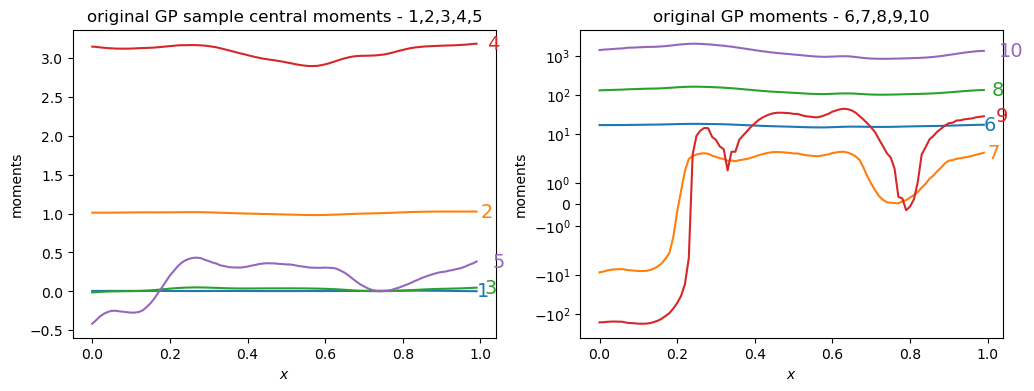

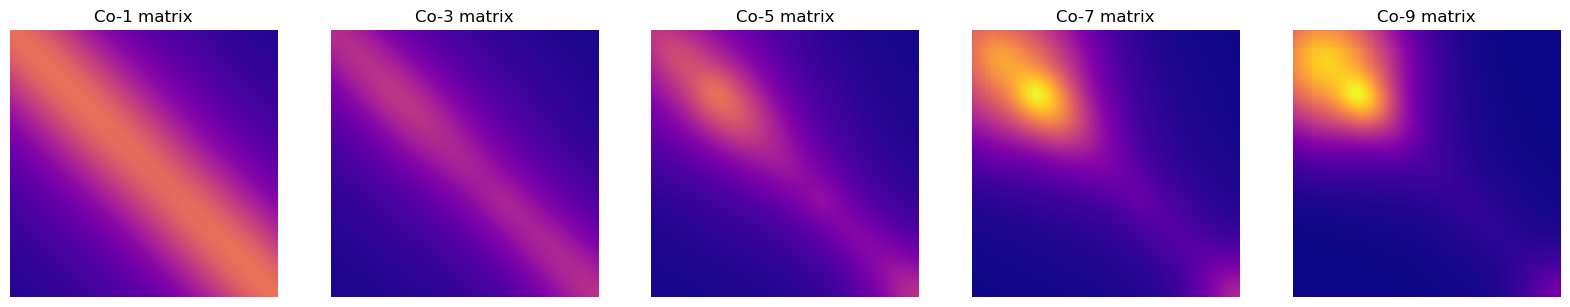

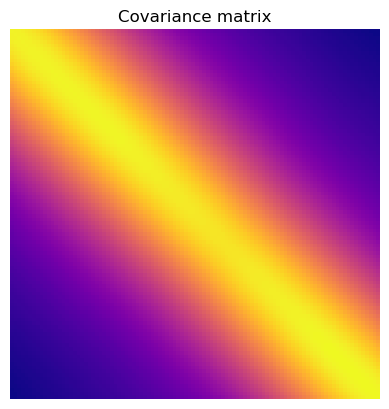

In [59]:
import matplotlib.pyplot as plt
from reusable.gp import OneDGP
from plotting.plots import plot_moments, plot_matrix
from reusable.moments import sample_central_moment, covariance, cokurtosis

from reusable.kernels import euclidian_dist


def esq_kernel(x, z, var, length, noise=0, jitter=1.0e-6):
    """For GPs only!!! as it returns a matrix"""
    dist = euclidian_dist(x, z)
    deltaXsq = jnp.power(dist / length, 2.0)
    k = var * jnp.exp(-0.5 * deltaXsq)
    k += (noise + jitter) * jnp.eye(x.shape[0])
    return k + jnp.ones((args["n"], args["n"]))

gp_predictive = Predictive(OneDGP, num_samples=10000)
gp_draws = gp_predictive(rng_key_gp, x=args["x"], gp_kernel = args["gp_kernel"], jitter=1e-5)['y']

moments_compareA = [1,2,3,4, 5]
moments_compareB = [6,7,8,9, 10]

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

gp_momentsA = [sample_central_moment(i, gp_draws) for i in moments_compareA]
plot_moments(gp_momentsA, moments_compareA, args["x"], "original GP sample central moments - " + ",".join([str(x) for x in moments_compareA]), ax=ax[0])

gp_momentsB = [sample_central_moment(i, gp_draws) for i in moments_compareB]
plot_moments(gp_momentsB, moments_compareB, args["x"], "original GP moments - " + ",".join([str(x) for x in moments_compareB]), scale="symlog", ax=ax[1])

mats = []

orders = [1,3,5,7,9]

mat_fig, mat_axs = plt.subplots(nrows=1, ncols=len(orders), figsize=(4 * len(orders), 4))

for  i, order in enumerate(orders):
    mats.append(cokurtosis(gp_draws, order))

vmin = min([jnp.min(m, axis=None) for m in mats])

vmax = max([jnp.max(m, axis=None) for m in mats])
for i, order in enumerate(orders):
    plot_matrix(mats[i], f"Co-{order} matrix", vmin=vmin, vmax=vmax, ax=mat_axs[i])

plot_matrix(covariance(gp_draws, ), "Covariance matrix")




# Comparing training plots

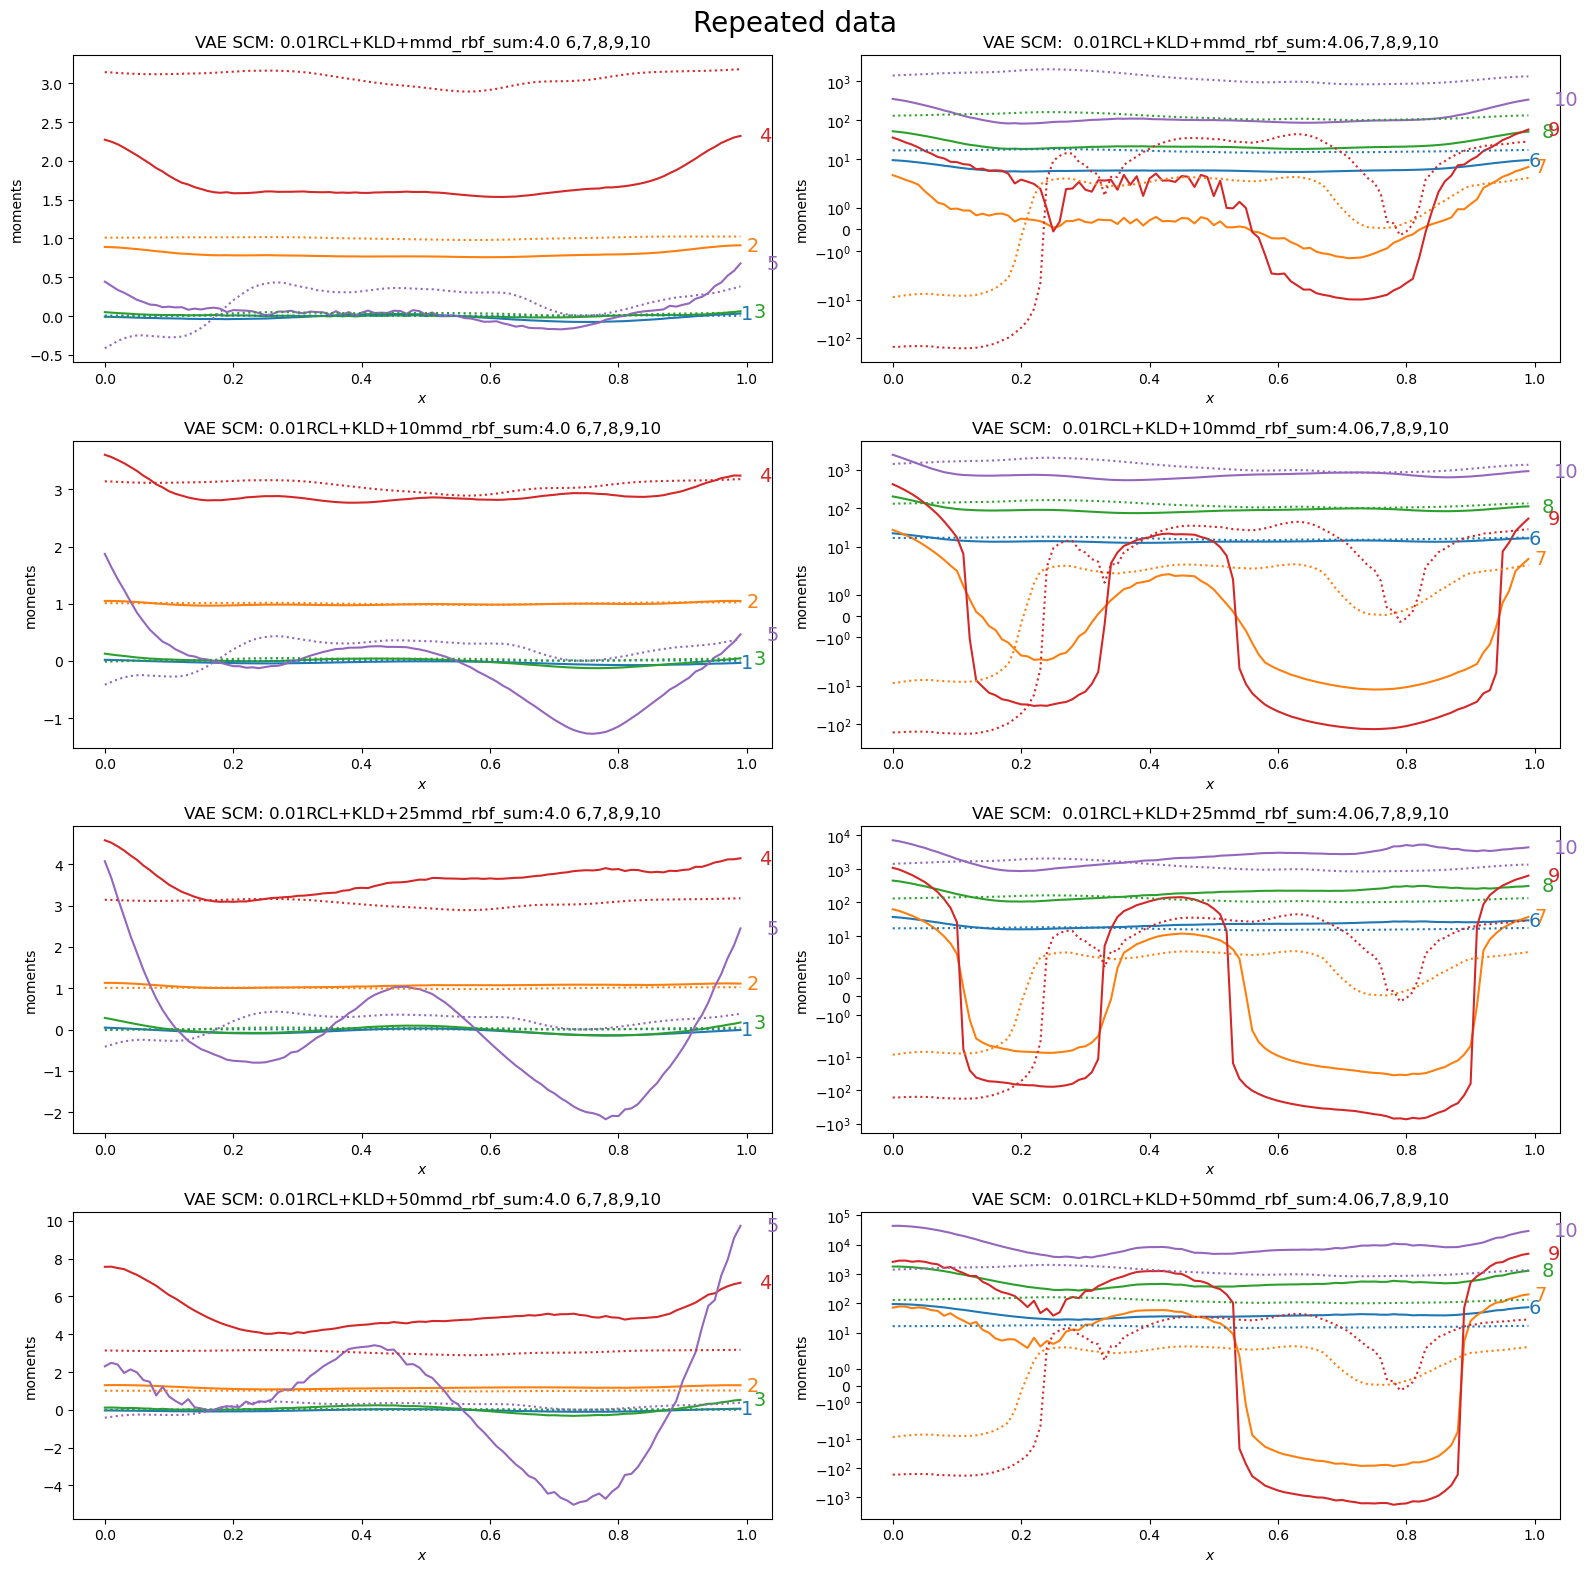

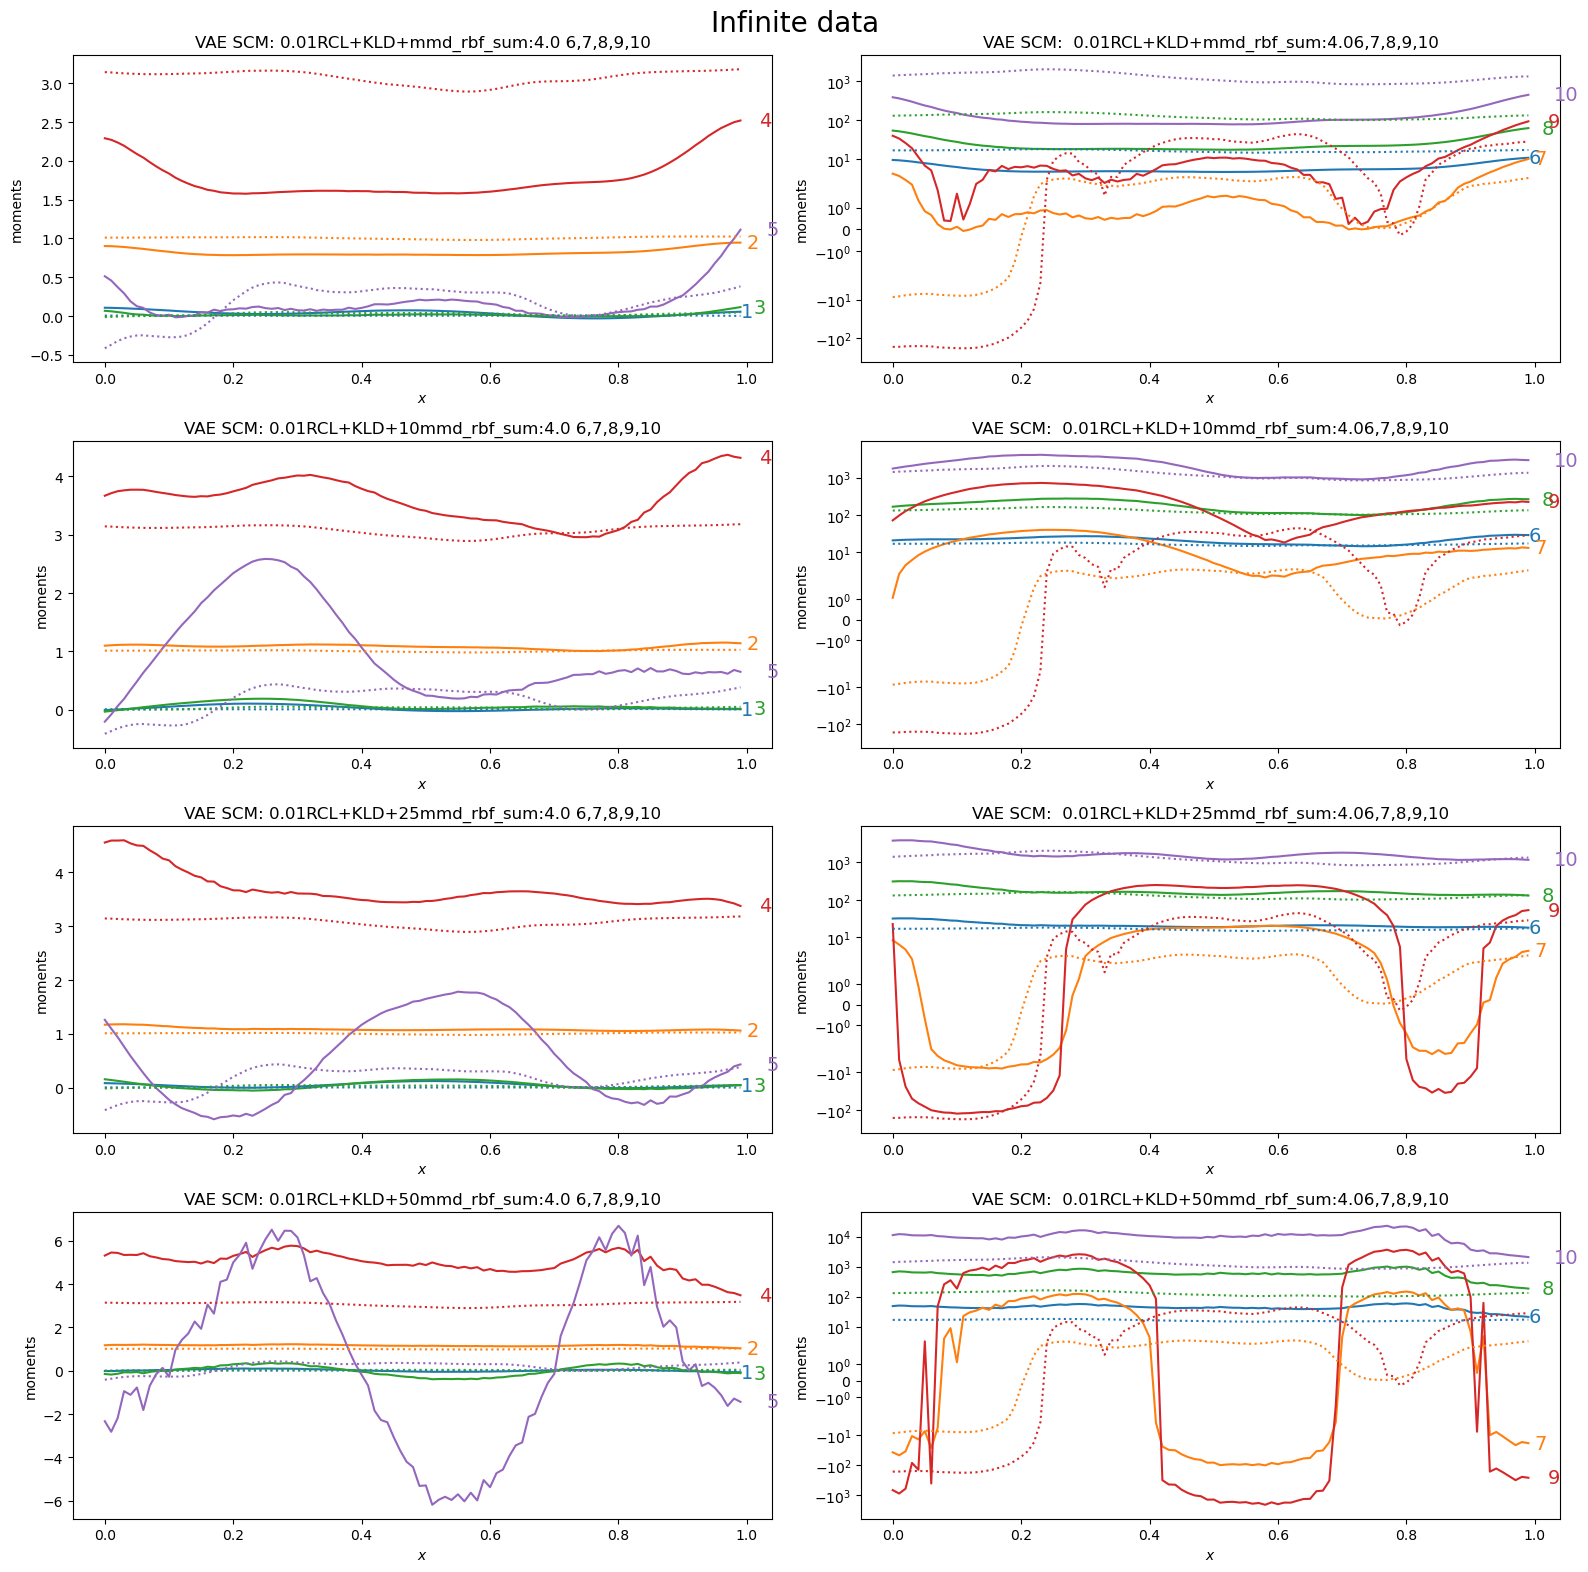

In [60]:
from plotting.plots import plot_moments
moments_fig, moments_ax = plt.subplots(nrows=len(args["loss_functions"]), ncols=2, figsize=(16, 16))
moments_fig.suptitle("Repeated data", fontsize=20)
inf_moments_fig, inf_moments_ax = plt.subplots(nrows=len(args["loss_functions"]), ncols=2, figsize=(16, 16))
inf_moments_fig.suptitle("Infinite data", fontsize=20)

for i, loss_fn in enumerate(args["loss_functions"]):
    for j in [0,1]:
        infinite = j ==0
        ax = inf_moments_ax if infinite else moments_ax

        try:
            vae_draws = gen_draws[f"{loss_fn}_{j}"]

            
            vae_momentsA = [sample_central_moment(i, vae_draws) for i in moments_compareA]
            vae_momentsB = [sample_central_moment(i, vae_draws) for i in moments_compareB]

            plot_moments(vae_momentsA, moments_compareA, args["x"], f"VAE SCM: {loss_fn} " + ",".join([str(x) for x in moments_compareB]), ax=ax[i, 0], correct_moments=gp_momentsA)
            plot_moments(vae_momentsB, moments_compareB, args["x"], f"VAE SCM:  {loss_fn}" + ",".join([str(x) for x in moments_compareB]), ax=ax[i, 1], correct_moments=gp_momentsB, scale="symlog")

        except KeyError:
            print(f"Failed to load decoder params for loss_fn={loss_fn}, j={j}")

inf_moments_fig.tight_layout()
moments_fig.tight_layout()

## Matrices

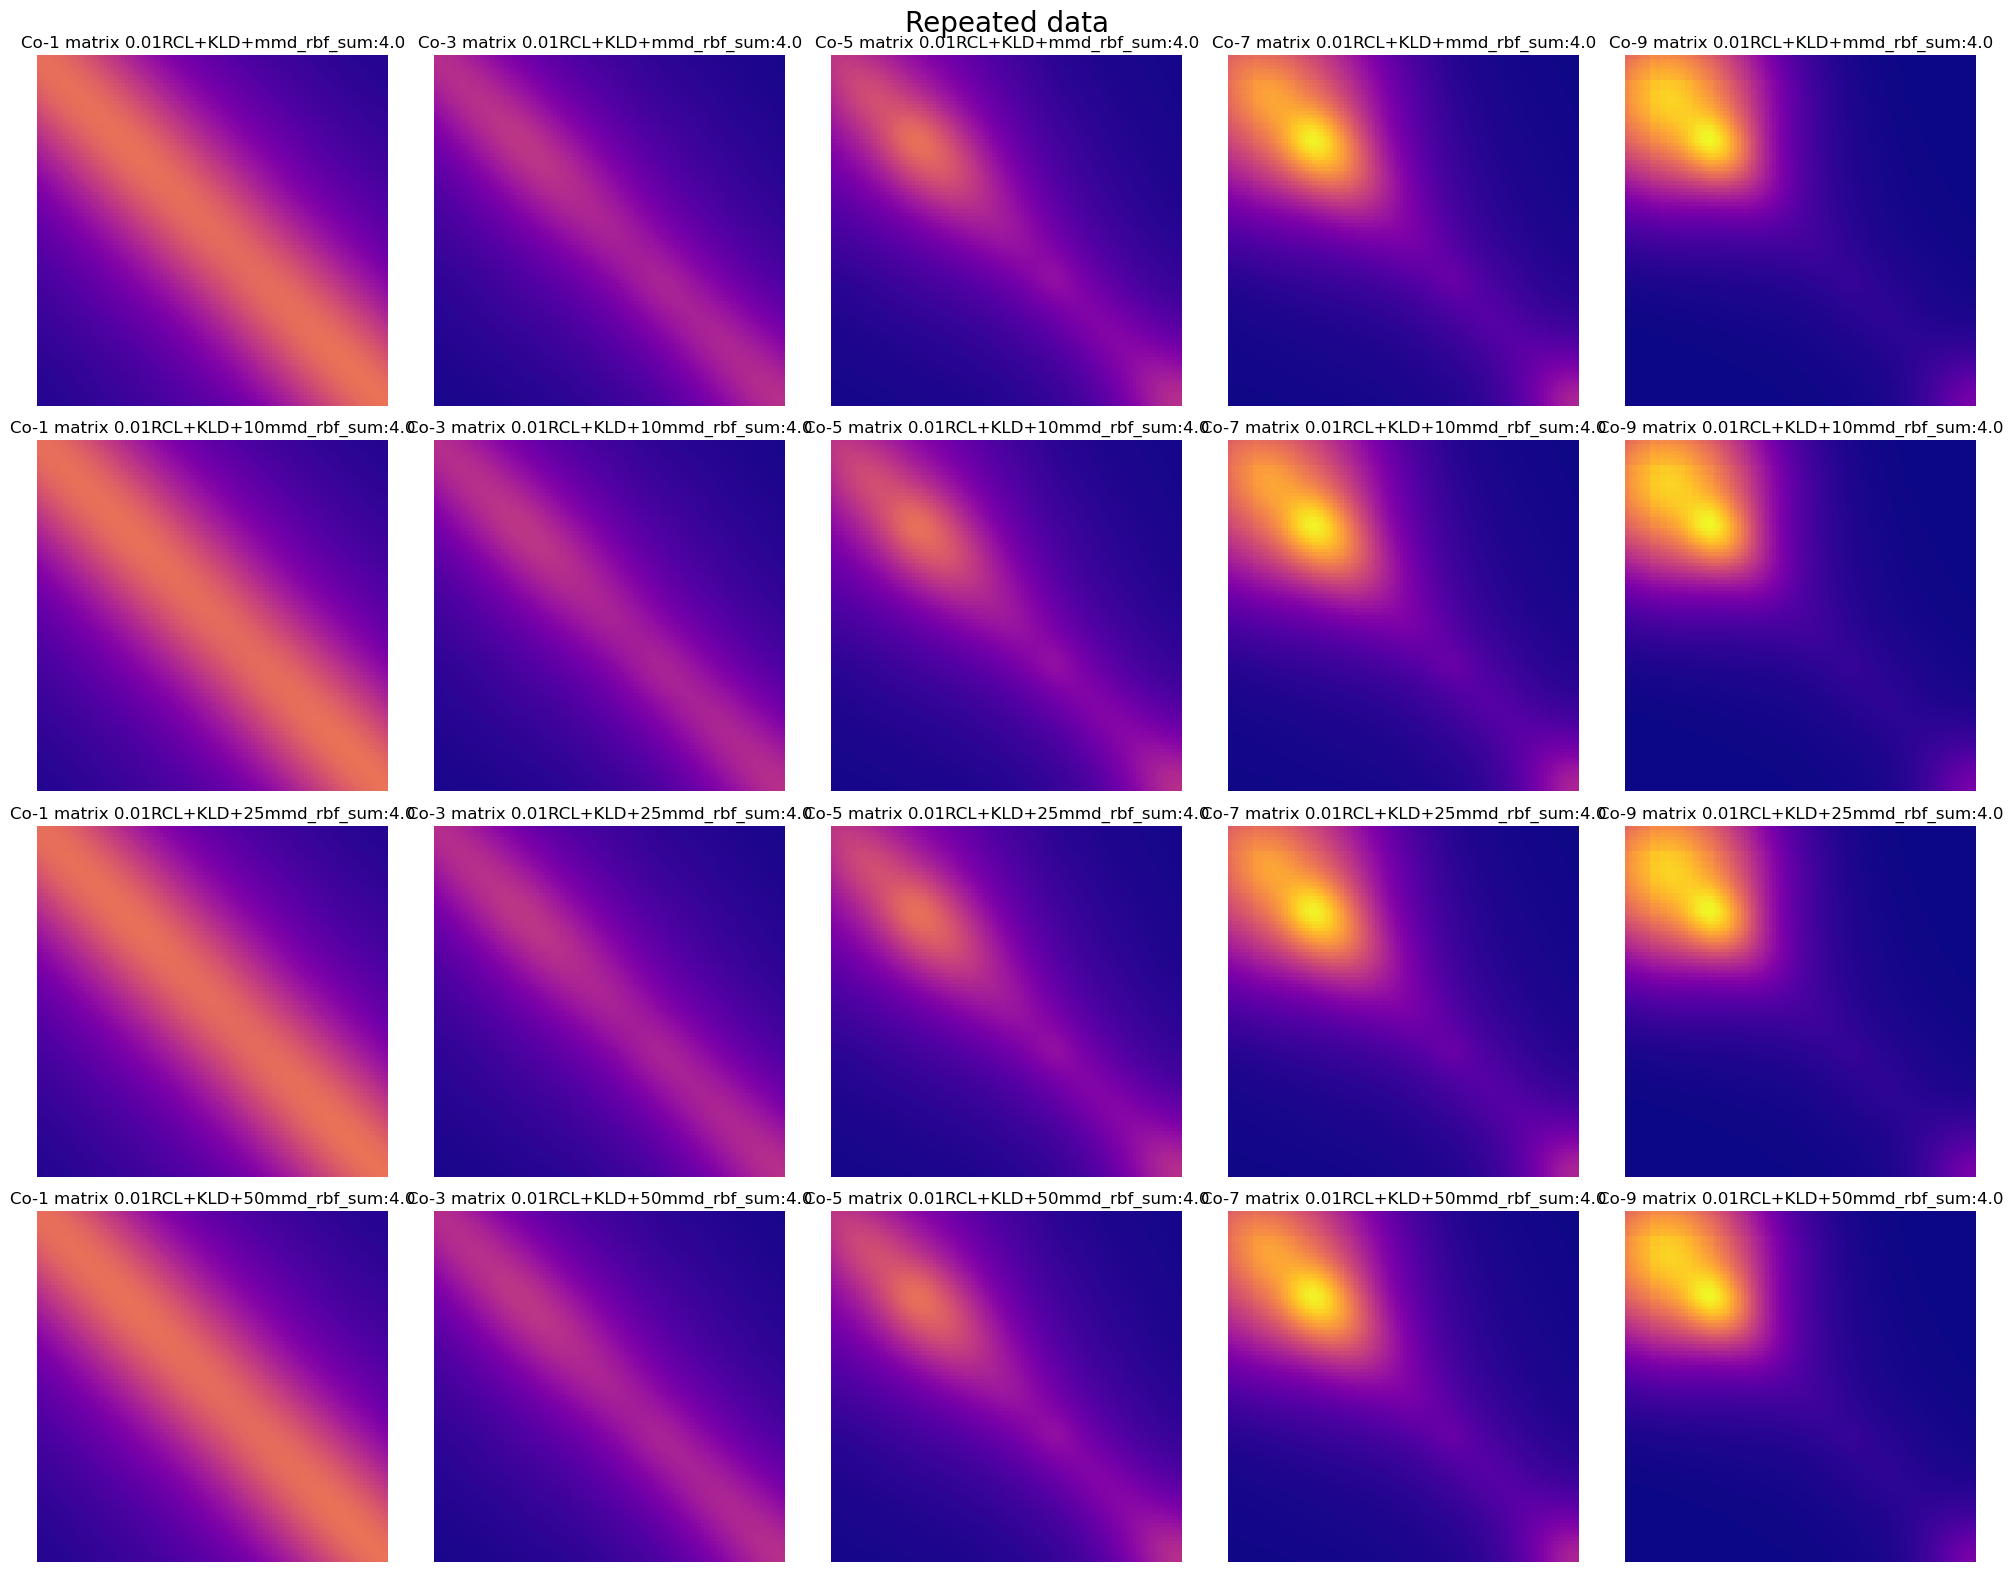

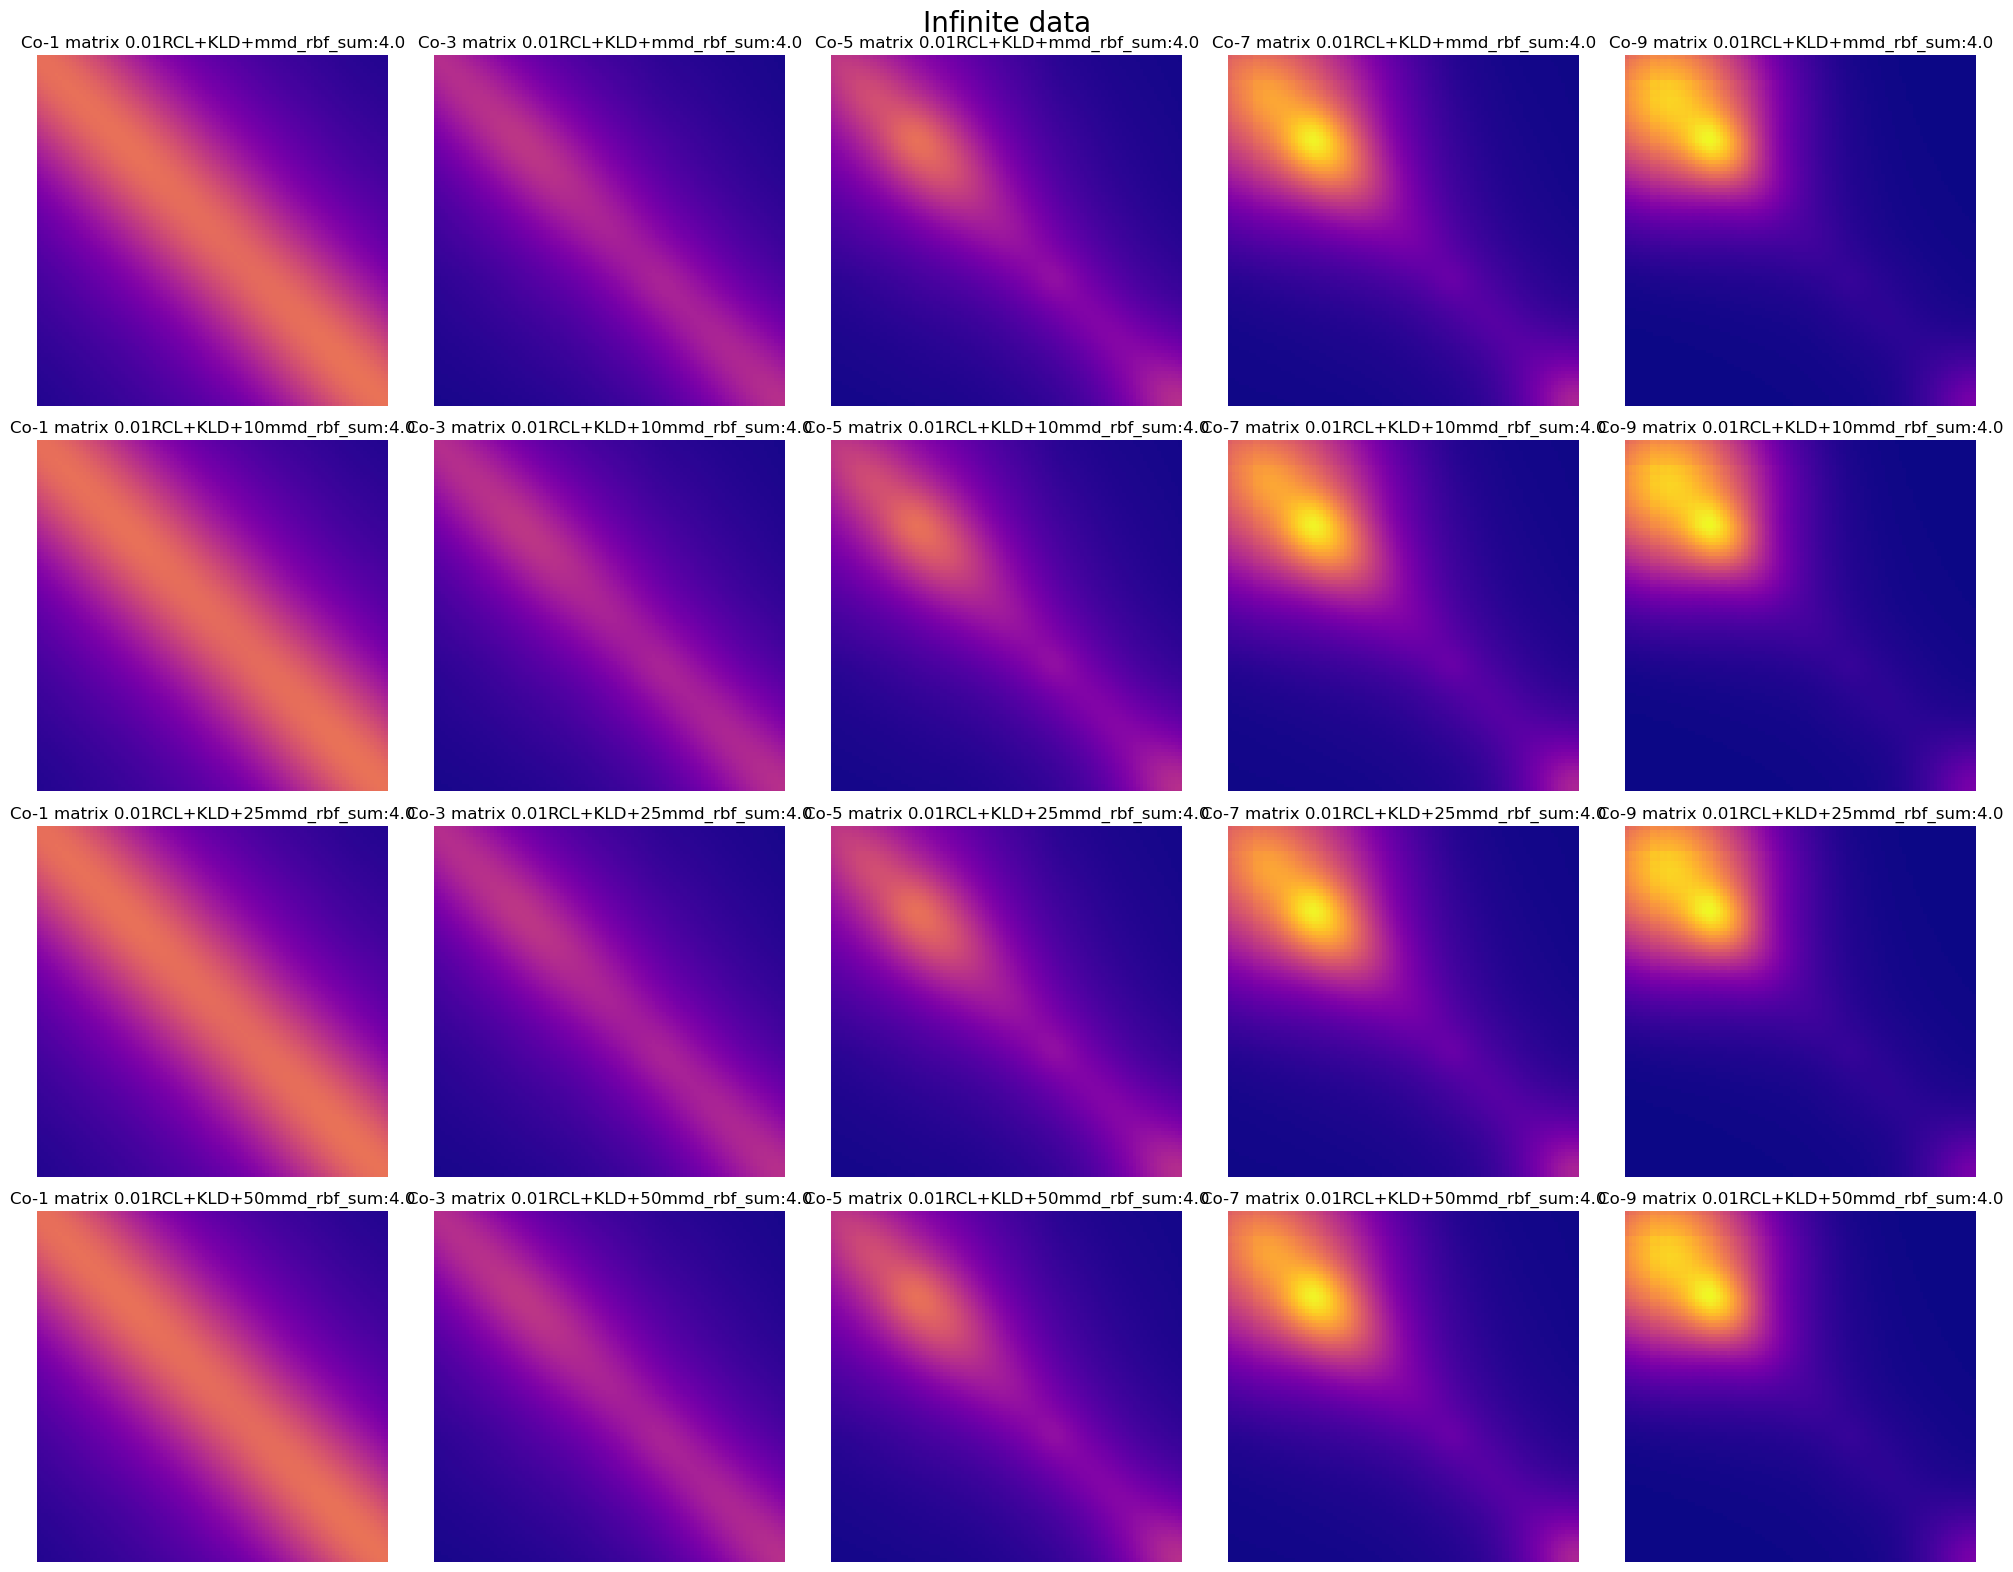

In [63]:
lmat_fig, lmat_axs = plt.subplots(nrows=len(args["loss_functions"]), ncols=len(orders), figsize=(4 * len(orders), 4 * len(args["loss_functions"])))
lmat_fig.suptitle("Repeated data", fontsize=20)

inf_lmat_fig, inf_lmat_axs = plt.subplots(nrows=len(args["loss_functions"]), ncols=len(orders), figsize=(4 * len(orders), 4 * len(args["loss_functions"])))

inf_lmat_fig.suptitle("Infinite data", fontsize=20)


for i, loss_fn in enumerate(args["loss_functions"]):
    for j in [0,1]:
        infinite = j ==0
        ax = inf_lmat_axs if infinite else lmat_axs

        try:
            vae_draws = gen_draws[f"{loss_fn}_{j}"]
           

            for k, order in enumerate(orders):
                mats.append(cokurtosis(vae_draws, order))

            # vmin = min([jnp.min(m, axis=None) for m in mats])

            # vmax = max([jnp.max(m, axis=None) for m in mats])
            for k, order in enumerate(orders):
                plot_matrix(mats[k], f"Co-{order} matrix {loss_fn}", vmin=vmin, vmax=vmax, ax=ax[i,k])
           
        except KeyError:
            print(f"Failed to load decoder params for loss_fn={loss_fn}, j={j}")

inf_lmat_fig.tight_layout()
lmat_fig.tight_layout()